# Detectiemodel en preprocessing

In [1]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
from skimage.filters import threshold_sauvola
from skimage.morphology import reconstruction, remove_small_objects, binary_opening, disk, binary_erosion
import numpy as np
import tensorflow as tf
import torch
from torch.utils.data import Dataset
from torch_geometric.data import Data
import networkx as nx
from skimage.filters import threshold_otsu, gaussian
from skimage.morphology import skeletonize, binary_dilation
from skimage.transform import resize
from torch_geometric.utils import dense_to_sparse
from torch_geometric.utils import remove_self_loops
import warnings
from torch_geometric.nn import VGAE
import torch.nn.functional as F
from torch_geometric.nn import GINConv, JumpingKnowledge
from torch_geometric.loader import DataLoader

In [2]:
model_path = r"C:\Users\lenka\OneDrive\Documenten\Afstuderen Master\pipeline\detectie_model.tflite"
image_path = r"C:\Users\lenka\OneDrive\Documenten\Afstuderen Master\eigen data\krassen\new_image4.jpg"

# Detectie model

[DEBUG] Originele afbeelding: breedte=3280, hoogte=2464
Loading C:\Users\lenka\OneDrive\Documenten\Afstuderen Master\pipeline\detectie_model.tflite for TensorFlow Lite inference...



c:\Users\lenka\anaconda3\envs\TataSteel2\lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


image 1/1 C:\Users\lenka\OneDrive\Documenten\Afstuderen Master\eigen data\krassen\new_image4.jpg: 160x160 1 display, 7.1ms
Speed: 3.1ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 160, 160)


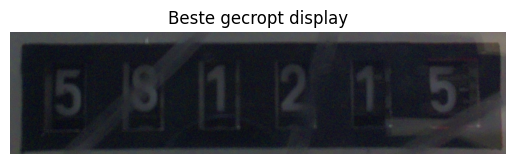

Geen rotatie nodig.


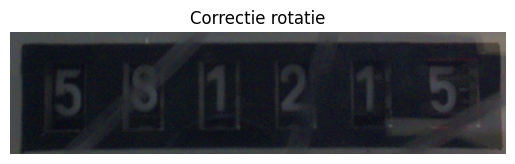

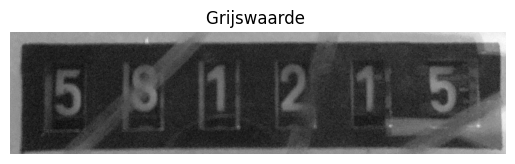

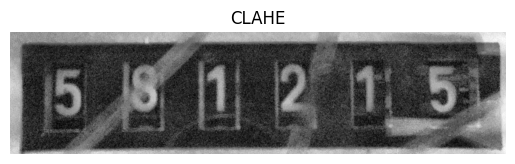

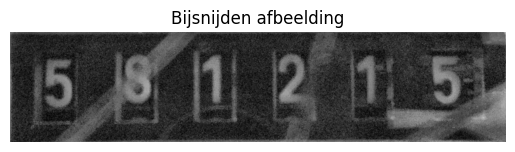

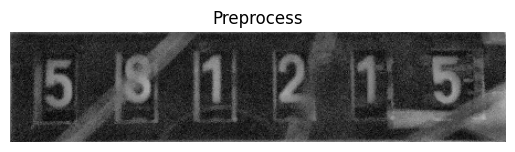

In [3]:
################ DETECTIE ###############

# Laad model
model = YOLO(model_path, task='detect')

# Laad originele afbeelding
original_img = cv2.imread(image_path)
orig_h, orig_w = original_img.shape[:2]
print(f"[DEBUG] Originele afbeelding: breedte={orig_w}, hoogte={orig_h}")

# Predictie
results = model.predict(source=image_path, save=False, imgsz=160)

# Begin van verbeterde logica (deze vervangt je oude box-handling)
boxes = results[0].boxes

if boxes is not None and len(boxes) > 0:
    # Zet alle boxen en hun confidence in lijst
    box_data = []
    for box in boxes:
        conf = float(box.conf[0].cpu().numpy())
        cls = int(box.cls[0].cpu().numpy()) if box.cls is not None else -1
        xyxy = box.xyxy[0].cpu().numpy()
        box_data.append((conf, cls, xyxy))

    # Sorteer op confidence (hoogste eerst)
    box_data.sort(reverse=True, key=lambda x: x[0])

    if len(box_data) > 0:
        _, _, box = box_data[0]
        x1, y1, x2, y2 = map(int, box)

        # Clamp de box binnen afbeelding
        x1 = max(0, min(orig_w - 1, x1))
        x2 = max(0, min(orig_w, x2))
        y1 = max(0, min(orig_h - 1, y1))
        y2 = max(0, min(orig_h, y2))

        cropped_display = original_img[y1:y2, x1:x2]


        # Toon de crop
        plt.imshow(cv2.cvtColor(cropped_display, cv2.COLOR_BGR2RGB))
        plt.title("Beste gecropt display")
        plt.axis("off")
        plt.show()
    else:
        print("Geen geschikte boxen gevonden.")
else:
    print("Geen objecten gedetecteerd.")

############## ROTEREN ##############################3
import numpy as np

# === Canny edge detection ===
edges = cv2.Canny(cropped_display, 50, 150, apertureSize=3)

# === Hough Line Transform ===
lines = cv2.HoughLines(edges, 1, np.pi / 180, 100)

lines = cv2.HoughLines(edges, 1, np.pi / 180, 100)

angles = []
if lines is not None:
    for rho, theta in lines[:, 0]:
        deg = np.degrees(theta)
        if abs(deg - 90) < 15:
            angles.append(deg - 90)

if len(angles) > 0:
    median_angle = round(np.median(angles) * 2) / 2.0
    print(f"[DEBUG] Rotatiehoek op crop: {median_angle:.2f}°")

    (h, w) = cropped_display.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, median_angle, 1.0)
    rotated_display = cv2.warpAffine(cropped_display, M, (w, h),
                                     flags=cv2.INTER_CUBIC,
                                     borderMode=cv2.BORDER_REPLICATE)
else:
    print("Geen rotatie nodig.")
    rotated_display = cropped_display.copy()

# Toon het resultaat
plt.imshow(cv2.cvtColor(rotated_display, cv2.COLOR_BGR2RGB))
plt.title("Correctie rotatie")
plt.axis("off")
plt.show()

################################# GRIJS ######################
gray_display = cv2.cvtColor(rotated_display, cv2.COLOR_BGR2GRAY)

plt.imshow(gray_display, cmap='gray')
plt.title("Grijswaarde ")
plt.axis("off")
plt.show()


######################### RUIS ETC. ###################
# Verwijder ruis & verhoog contrast
# blurred = cv2.medianBlur(gray_display, 3)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
enhanced = clahe.apply(gray_display)
plt.imshow(enhanced, cmap='gray')
plt.title("CLAHE")
plt.axis("off")
plt.show()


########################### TRIM ##################################
def smart_trim(image, threshold=200, max_trim=50, white_ratio=0.90, lookahead=5):
    """
    Trim witte randen met pixelanalyse per rij/kolom en lookahead om vals stoppen te vermijden.
    """
    if len(image.shape) == 2:
        gray = image
    else:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    h, w = gray.shape

    top, bottom = 0, h
    left, right = 0, w

    # Bovenkant
    for y in range(max_trim):
        row = gray[y, :]
        ratio = np.sum(row > threshold) / w
        if ratio < white_ratio:
            lookahead_rows = gray[y+1:y+1+lookahead, :]
            lookahead_ratios = np.mean(np.sum(lookahead_rows > threshold, axis=1) / w)
            if lookahead_ratios < white_ratio:
                break
        top += 1

    # Onderkant
    for y in range(h - 1, h - max_trim - 1, -1):
        row = gray[y, :]
        ratio = np.sum(row > threshold) / w
        if ratio < white_ratio:
            lookahead_rows = gray[max(0, y-lookahead):y, :]
            lookahead_ratios = np.mean(np.sum(lookahead_rows > threshold, axis=1) / w)
            if lookahead_ratios < white_ratio:
                break
        bottom -= 1

    # Linkerkant
    for x in range(max_trim):
        col = gray[:, x]
        ratio = np.sum(col > threshold) / h
        if ratio < white_ratio:
            lookahead_cols = gray[:, x+1:x+1+lookahead]
            lookahead_ratios = np.mean(np.sum(lookahead_cols > threshold, axis=0) / h)
            if lookahead_ratios < white_ratio:
                break
        left += 1

    # Rechterkant
    for x in range(w - 1, w - max_trim - 1, -1):
        col = gray[:, x]
        ratio = np.sum(col > threshold) / h
        if ratio < white_ratio:
            lookahead_cols = gray[:, max(0, x-lookahead):x]
            lookahead_ratios = np.mean(np.sum(lookahead_cols > threshold, axis=0) / h)
            if lookahead_ratios < white_ratio:
                break
        right -= 1

    if right > left and bottom > top:
        return image[top:bottom, left:right]
    else:
        print(" Ongeldige smart crop — origineel teruggegeven.")
        return image

trimmed = smart_trim(enhanced, threshold=100, max_trim=60, white_ratio=0.80, lookahead=30)
# trimmed = smart_trim(enhanced, threshold=200, max_trim=50, white_ratio=0.90, lookahead=5)


plt.imshow(cv2.cvtColor(trimmed, cv2.COLOR_BGR2RGB))
plt.title("Bijsnijden afbeelding")
plt.axis("off")
plt.show()



#################################### NORMALISEREN ########################
def normalize_height(image, target_height=100):
    h, w = image.shape[:2]
    scale = target_height / h
    new_w = int(w * scale)
    resized = cv2.resize(image, (new_w, target_height), interpolation=cv2.INTER_CUBIC)
    return resized

normalized = normalize_height(trimmed, target_height=100)

plt.imshow(cv2.cvtColor(normalized, cv2.COLOR_BGR2RGB))
plt.title("Preprocess")
plt.axis("off")
plt.show()



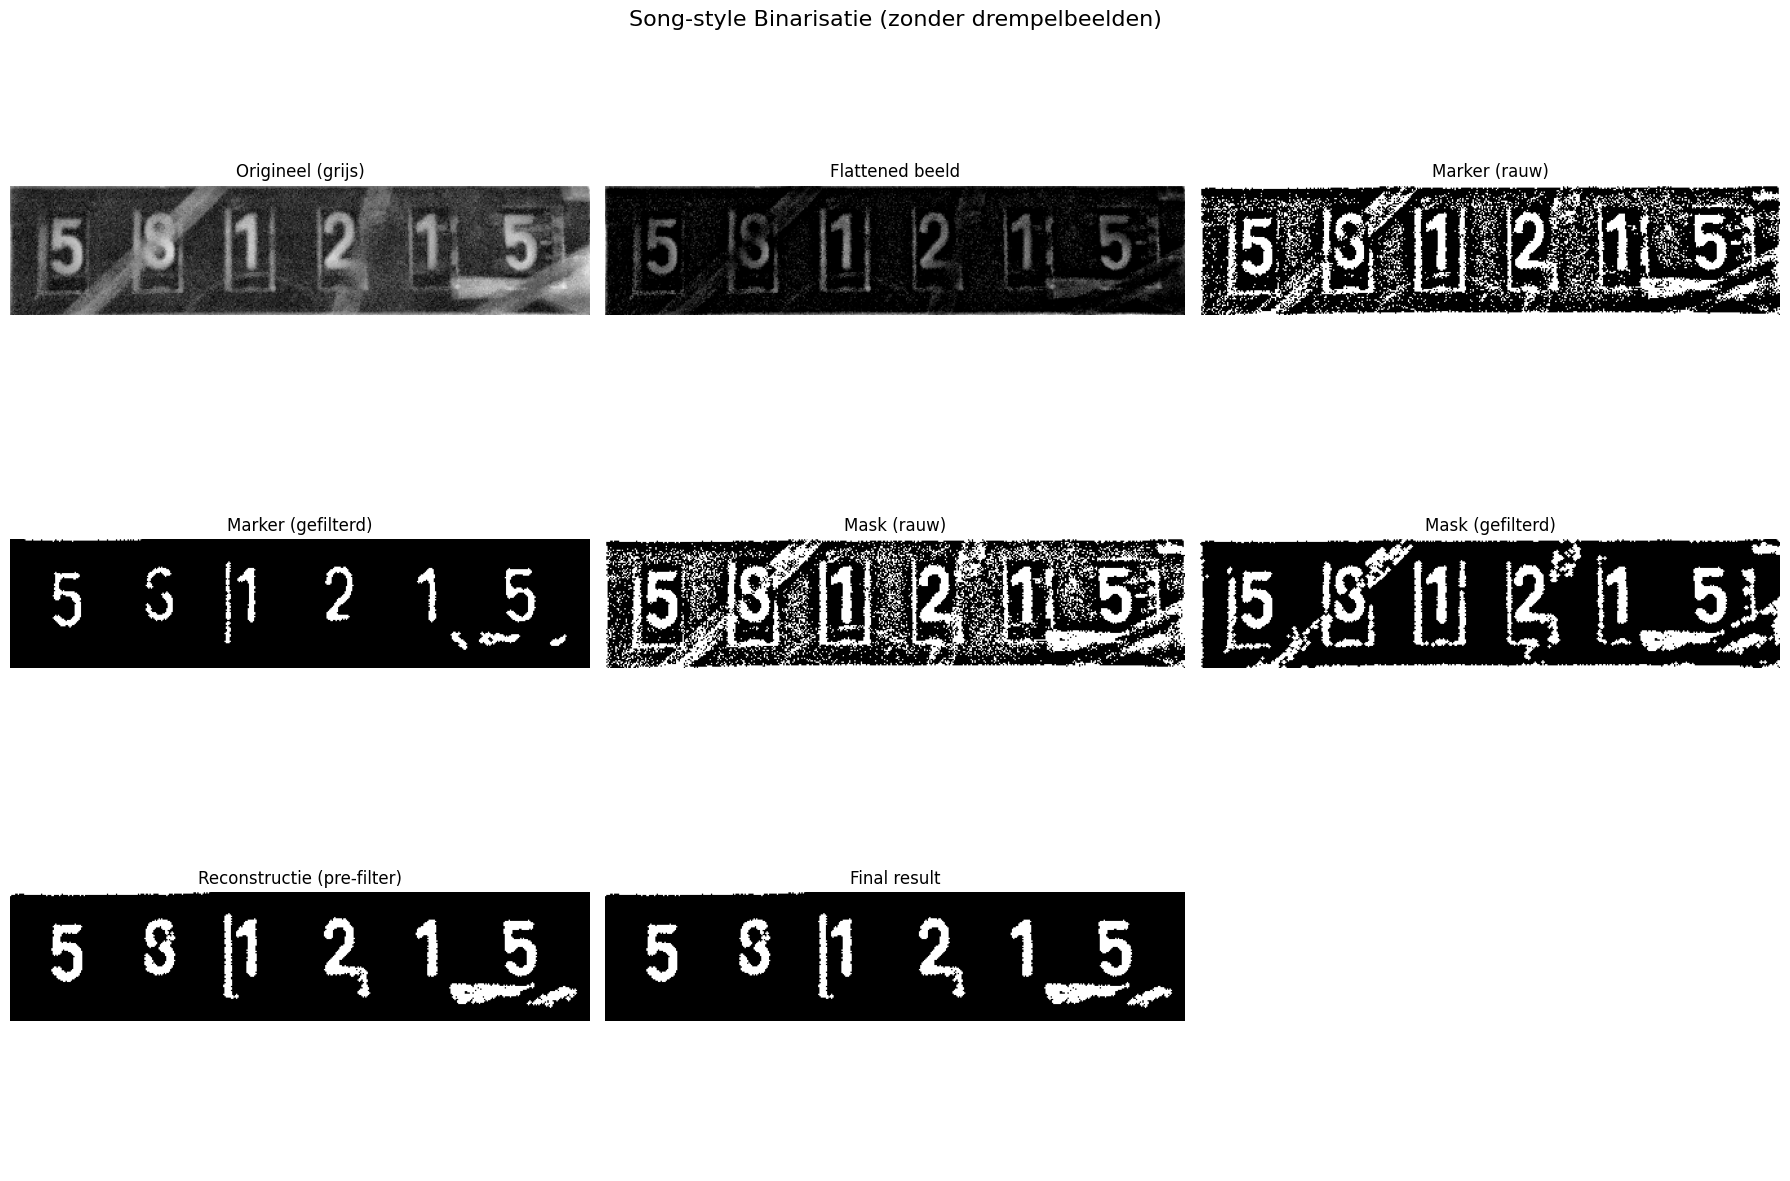

In [4]:
# === Parameters ===
window = 25
k_strict = -0.1
k_soft = 0.5
min_marker_size = 150
min_final_size = 150
blur_size = 35

# === 1. Flatten achtergrond ===
blurred_bg = cv2.GaussianBlur(normalized, (blur_size, blur_size), 0)

flattened = cv2.subtract(normalized, blurred_bg)
flattened = cv2.normalize(flattened, None, 0, 255, cv2.NORM_MINMAX)

# === 2. Bereken thresholds ===
t_strict = threshold_sauvola(flattened, window_size=window, k=k_strict)
t_soft = threshold_sauvola(flattened, window_size=window, k=k_soft)

# === 3. Binariseer ===
marker_raw = (flattened > t_strict)
mask_raw = (flattened > t_soft)

# === 4. Filter marker ===
marker = remove_small_objects(marker_raw, min_size=min_marker_size)
marker = binary_opening(marker, disk(2))
marker = binary_opening(marker, disk(1))
marker = binary_erosion(marker, disk(1))
# marker = binary_erosion(marker, disk(1))
 # optioneel
marker = remove_small_objects(marker, min_size=50)
# === 5. Filter mask ===
mask = remove_small_objects(mask_raw, min_size=150)
mask = binary_opening(mask, disk(1))

# === 6. Reconstructie ===
recon = reconstruction(seed=marker, mask=mask, method='dilation')

# === 7. Morph. opening ===
opened = binary_opening(recon, disk(1))

# === 8. Laatste ruisfiltering ===
cleaned = remove_small_objects(opened, min_size=min_final_size)

# === 9. Final naar uint8 ===
final_result = (cleaned.astype(np.uint8)) * 255

# === 10. Visualisatie ===
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

axes[0].imshow(normalized, cmap='gray')
axes[0].set_title("Origineel (grijs)")

axes[1].imshow(flattened, cmap='gray')
axes[1].set_title("Flattened beeld")

axes[2].imshow(marker_raw.astype(np.uint8) * 255, cmap='gray')
axes[2].set_title("Marker (rauw)")

axes[3].imshow(marker.astype(np.uint8) * 255, cmap='gray')
axes[3].set_title("Marker (gefilterd)")

axes[4].imshow(mask_raw.astype(np.uint8) * 255, cmap='gray')
axes[4].set_title("Mask (rauw)")

axes[5].imshow(mask.astype(np.uint8) * 255, cmap='gray')
axes[5].set_title("Mask (gefilterd)")

axes[6].imshow((recon.astype(np.uint8)) * 255, cmap='gray')
axes[6].set_title("Reconstructie (pre-filter)")

axes[7].imshow(final_result, cmap='gray')
axes[7].set_title("Final result")

axes[8].axis('off')

for ax in axes:
    ax.axis('off')

plt.suptitle("Song-style Binarisatie (zonder drempelbeelden)", fontsize=16)
plt.tight_layout()
plt.show()


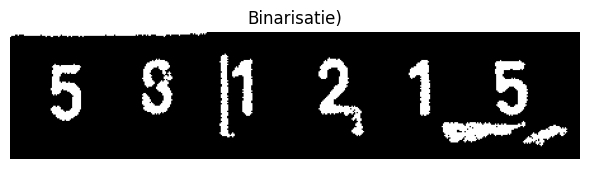

In [5]:
# Extra visualisatie: final_result los
plt.figure(figsize=(6, 3))
plt.imshow(final_result, cmap='gray')
plt.title("Binarisatie)")
plt.axis('off')
plt.tight_layout()
plt.show()


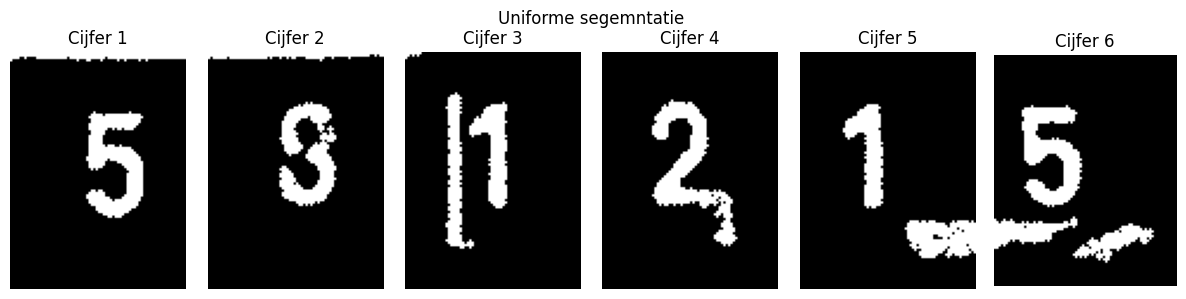

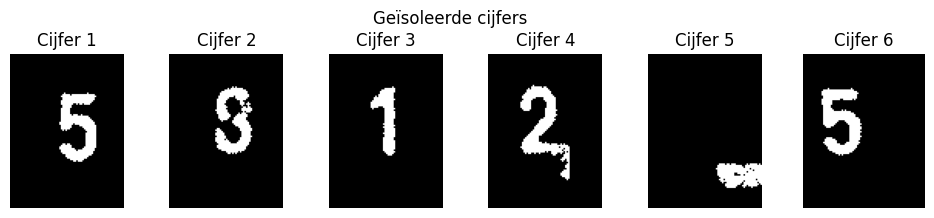

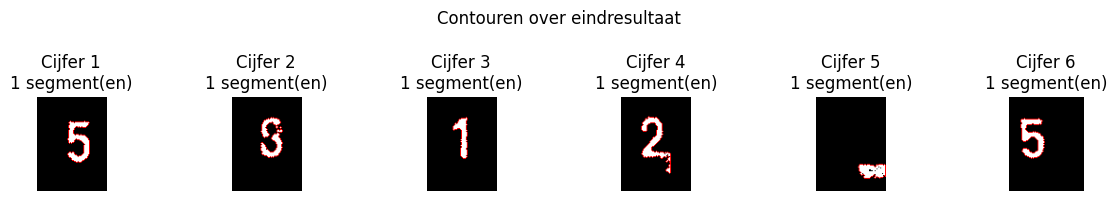

In [6]:
# Functie om horizontale lijnen te verwijderen
def remove_horizontal_lines(img, line_min_width=20):
    inverted = 255 - img
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (line_min_width, 1))
    detect_horizontal = cv2.morphologyEx(inverted, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
    cleaned = cv2.subtract(img, detect_horizontal)
    return cleaned

# Functie om segment te reinigen
def clean_digit_segment(segment):
    segment = segment.copy()
    if segment.max() <= 1:
        segment = (segment * 255).astype(np.uint8)

    segment = remove_horizontal_lines(segment)

    kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.morphologyEx(segment, cv2.MORPH_OPEN, kernel, iterations=1)
    return cleaned

# Functie om hoofdcomponent te extraheren
def extract_main_component_filtered(crop_bin, y_margin=20, min_y=10):
    crop_bin = (crop_bin > 0).astype(np.uint8) * 255
    contours, _ = cv2.findContours(crop_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    valid_contours = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = cv2.contourArea(cnt)
        rect_area = w * h
        extent = area / rect_area if rect_area > 0 else 0
        if y >= min_y and extent > 0.2 and 0.1 < w/h < 3.0:
            valid_contours.append(cnt)

    if not valid_contours and contours:
        valid_contours = [max(contours, key=cv2.contourArea)]

    if not valid_contours:
        return np.zeros_like(crop_bin)

    main_contour = max(valid_contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(main_contour)
    y_min, y_max = y, y + h

    output = np.zeros_like(crop_bin)
    for cnt in valid_contours:
        _, y_cnt, _, h_cnt = cv2.boundingRect(cnt)
        if (y_cnt >= y_min - y_margin) and (y_cnt + h_cnt <= y_max + y_margin):
            cv2.drawContours(output, [cnt], -1, 255, thickness=cv2.FILLED)

    return output

# Functie om uiteindelijke cijfer te extraheren
def extract_preserved_digit(original_segment, min_y=10, y_margin=20, max_y_ratio=0.85):
    original_bin = (original_segment > 0).astype(np.uint8) * 255
    cleaned = clean_digit_segment(original_bin)
    contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    hoogte = original_bin.shape[0]
    max_y_abs = int(hoogte * max_y_ratio)

    valid_contours = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        midden = y + h // 2
        area = cv2.contourArea(cnt)
        rect_area = w * h
        extent = area / rect_area if rect_area > 0 else 0
        if min_y <= midden <= max_y_abs and h > 10 and w > 5 and extent > 0.2 and 0.1 < w/h < 3.0:
            valid_contours.append(cnt)

    if not valid_contours and contours:
        valid_contours = [max(contours, key=cv2.contourArea)]

    if not valid_contours:
        return np.zeros_like(original_bin)

    largest_contour = max(valid_contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

    mask = np.zeros_like(original_bin)
    y_start = max(0, y - y_margin)
    y_end = min(original_bin.shape[0], y + h + y_margin)
    x_start = max(0, x - 5)
    x_end = min(original_bin.shape[1], x + w + 5)
    mask[y_start:y_end, x_start:x_end] = 1

    final_digit = (original_bin * mask).astype(np.uint8)

    contours_final, _ = cv2.findContours(final_digit, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours_final:
        return np.zeros_like(original_bin)

    best_contour = max(contours_final, key=cv2.contourArea)
    result = np.zeros_like(original_bin)
    cv2.drawContours(result, [best_contour], -1, 255, thickness=cv2.FILLED)

    return np.where((result == 255) & (original_bin == 255), 255, 0).astype(np.uint8)

# =========================== HOOFDPROCESSING ===========================

h, w = final_result.shape
n_digits = 6

digit_width = w // n_digits

digit_regions = []
plt.figure(figsize=(12, 3))
for i in range(n_digits):
    x_start = i * digit_width
    x_end = (i + 1) * digit_width if i < n_digits - 1 else w
    digit_crop = final_result[:, x_start:x_end]
    digit_regions.append(digit_crop)

    plt.subplot(1, n_digits, i + 1)
    plt.imshow(digit_crop, cmap='gray')
    plt.title(f'Cijfer {i+1}')
    plt.axis('off')
plt.suptitle("Uniforme segemntatie")
plt.tight_layout()
plt.show()

final_digits = []
plt.figure(figsize=(12, 2)) 
for i, region in enumerate(digit_regions):
    final_digit = extract_preserved_digit(region)
    final_digits.append(final_digit)

    plt.subplot(1, n_digits, i + 1)
    plt.imshow(final_digit, cmap='gray')
    plt.title(f'Cijfer {i+1}')
    plt.axis('off')

plt.suptitle("Geïsoleerde cijfers", y=1.1) 
plt.subplots_adjust(wspace=0.2)  
plt.show()

# Contourweergave
plt.figure(figsize=(12, 2))
for i, final_digit in enumerate(final_digits):
    color_digit = cv2.cvtColor(final_digit, cv2.COLOR_GRAY2BGR)
    contours, _ = cv2.findContours(final_digit, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(color_digit, contours, -1, (0, 0, 255), 1)

    display_img = cv2.cvtColor(color_digit, cv2.COLOR_BGR2RGB)
    plt.subplot(1, n_digits, i + 1)
    plt.imshow(display_img)
    plt.title(f'Cijfer {i+1}\n{len(contours)} segment(en)')
    plt.axis('off')
plt.suptitle("Contouren over eindresultaat")
plt.tight_layout()
plt.show()


# Classificatie

In [7]:
goede_cijfers = []
slechte_cijfers = []
slechte_cijfer_indexen = []
voorspelde_reeks = []  

# Laad TFLite model
interpreter = tf.lite.Interpreter(model_path=r"C:\Users\lenka\OneDrive\Documenten\Afstuderen Master\pipeline\final_model_full_train.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Verwerk input afbeeldingen
resized_digits = [cv2.resize(d, (64, 64), interpolation=cv2.INTER_AREA) for d in final_digits]  
input_digits = np.stack(resized_digits).astype(np.float32) / 255.0
input_digits = input_digits[..., np.newaxis]  

confidence_threshold = 0.80

In [8]:
goede_cijfers = []
slechte_cijfers = []
slechte_cijfer_indexen = []
slechte_cijfer_info = [] 
voorspelde_reeks = []

for i, digit in enumerate(input_digits):
    input_data = np.expand_dims(digit, axis=0)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    prediction = int(np.argmax(output_data))
    confidence = float(np.max(output_data))
    if confidence >= confidence_threshold:
        goede_cijfers.append(resized_digits[i])
        voorspelde_reeks.append((i, str(prediction)))
        print(f"[✓] Cijfer {i+1}: {prediction} ({confidence:.2%})")
    else:
        slechte_cijfers.append(resized_digits[i])
        slechte_cijfer_indexen.append(i)
        slechte_cijfer_info.append((i, prediction, confidence))  # nieuwe regel
        print(f"[✗] Cijfer {i+1}: {prediction} ({confidence:.2%}) → door naar GNN")


[✓] Cijfer 1: 5 (99.96%)
[✗] Cijfer 2: 9 (67.02%) → door naar GNN
[✓] Cijfer 3: 1 (99.86%)
[✓] Cijfer 4: 2 (94.06%)
[✓] Cijfer 5: 1 (80.52%)
[✓] Cijfer 6: 5 (89.61%)


# Reconstructie

In [9]:
# ----------------------------
# Preprocessing helpers
# ----------------------------

def resize_with_padding(img, target_size=64, inner_size=60):
    h, w = img.shape
    scale = min(inner_size / h, inner_size / w)
    new_h, new_w = int(h * scale), int(w * scale)
    resized = resize(img, (new_h, new_w), mode='constant', anti_aliasing=True)
    pad_h = target_size - new_h
    pad_w = target_size - new_w
    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left
    return np.pad(resized, ((top, bottom), (left, right)), mode='constant', constant_values=0)

def preprocess_image(img, target_size=64, inner_size=60):
    img = img / 255.0 if img.max() > 1 else img
    threshold = threshold_otsu(img)
    binary = img > threshold

    # Crop
    rows, cols = np.any(binary, axis=1), np.any(binary, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    margin = 1
    rmin = max(rmin - margin, 0)
    rmax = min(rmax + margin, img.shape[0] - 1)
    cmin = max(cmin - margin, 0)
    cmax = min(cmax + margin, img.shape[1] - 1)
    cropped = img[rmin:rmax+1, cmin:cmax+1]

    # Resize en binarisatie
    resized = resize_with_padding(cropped, target_size, inner_size)
    smoothed = gaussian(resized, sigma=1.0)
    binary = smoothed > threshold_otsu(smoothed)

    # Skeletonisatie
    skeleton1 = skeletonize(binary)
    dilated = binary_dilation(skeleton1)
    skeleton = skeletonize(dilated)
    return skeleton

def skeleton_to_graph(skeleton):
    coords = np.argwhere(skeleton)
    G = nx.Graph()
    for y, x in coords:
        G.add_node((x, y))
        for dy in [-1, 0, 1]:
            for dx in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                ny, nx_ = y + dy, x + dx
                if 0 <= ny < skeleton.shape[0] and 0 <= nx_ < skeleton.shape[1]:
                    if skeleton[ny, nx_]:
                        G.add_edge((x, y), (nx_, ny))
    return G

def project_graph_to_grid(G, grid_size=8, image_size=64):
    cell_size = image_size // grid_size
    G_projected = nx.Graph()
    point_to_cell = {}
    added_edges = set()

    for x, y in G.nodes:
        cx = int(x / cell_size)
        cy = int(y / cell_size)
        cell = (cx, cy)
        point_to_cell[(x, y)] = cell
        G_projected.add_node(cell)

    for u, v in G.edges:
        cu = point_to_cell.get(u)
        cv = point_to_cell.get(v)
        if cu and cv and cu != cv:
            edge = tuple(sorted((cu, cv)))
            if edge not in added_edges:
                G_projected.add_edge(*edge)
                added_edges.add(edge)

    return G_projected

def graph_to_pyg_data(G, grid_size=8, label=None):
    num_nodes = grid_size * grid_size
    node_index_map = { (x, y): y * grid_size + x for x in range(grid_size) for y in range(grid_size) }

    # Alleen identity-matrix als features (one-hot vector per knoop)
    features = []
    for y in range(grid_size):
        for x in range(grid_size):
            idx = y * grid_size + x
            one_hot = torch.zeros(num_nodes)
            one_hot[idx] = 1.0
            features.append(one_hot)

    x = torch.stack(features)  # Vorm: [64, 64]

    edge_index = []
    for (u, v) in G.edges:
        uid = node_index_map.get(u)
        vid = node_index_map.get(v)
        if uid is not None and vid is not None:
            edge_index.append([uid, vid])
            edge_index.append([vid, uid])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    data = Data(x=x, edge_index=edge_index)
    if label is not None:
        data.y = torch.tensor([label], dtype=torch.long)
    return data

class PyGSkeletonDataset(Dataset):
    def __init__(self, images, labels=None, grid_size=8):
        self.images = images
        self.labels = labels
        self.grid_size = grid_size
        self.graphs = [self._image_to_graph(img, i) for i, img in enumerate(images)]

    def _image_to_graph(self, img, idx):
        skeleton = preprocess_image(img)
        G = skeleton_to_graph(skeleton)
        G_proj = project_graph_to_grid(G, grid_size=self.grid_size)
        label = self.labels[idx] if self.labels is not None else None
        return graph_to_pyg_data(G_proj, grid_size=self.grid_size, label=label)

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx]



In [10]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [11]:
def reconstruct_edges(data, model, threshold=0.5):
    model.eval()
    data = data.to(device)
    with torch.no_grad():
        z = model.encode(data.x, data.edge_index)

    # Genereer alle mogelijke nodeparen in grid
    num_nodes = data.num_nodes
    row, col = torch.meshgrid(torch.arange(num_nodes), torch.arange(num_nodes), indexing='ij')
    full_edge_index = torch.stack([row.flatten(), col.flatten()], dim=0).to(device)

    # Decode scores (edge probabilities)
    scores = model.decode(z, full_edge_index).sigmoid()

    # Houd alleen edges boven drempel
    keep = scores > threshold
    edge_index_reconstructed = full_edge_index[:, keep]

    return edge_index_reconstructed.cpu()


def zijn_directe_buren(u, v):
    """Controleer of twee knopen directe buren zijn op een 8x8 raster, inclusief diagonalen."""
    x1, y1 = u % 8, u // 8
    x2, y2 = v % 8, v // 8
    return max(abs(x1 - x2), abs(y1 - y2)) == 1 and (u != v)


def filter_directe_buren(edge_index):
    """Behoud alleen edges tussen directe buren."""
    filtered_edges = []
    for u, v in edge_index.t().tolist():
        if zijn_directe_buren(u, v):
            filtered_edges.append((u, v))
    return torch.tensor(filtered_edges).t()

def plot_graph(edge_index, title, color='b'):
    G = nx.Graph()
    positions = {i: (i % 8, 7 - i // 8) for i in range(64)}  # rasterpositie

    edges = edge_index.t().tolist()
    G.add_edges_from(edges)
    G.add_nodes_from(range(64))  # voor zichtbare losse nodes

    nx.draw(
        G,
        pos=positions,
        node_size=100,
        edge_color=color,
        node_color='blue',
        with_labels=False
    )
    plt.title(title)

def show_comparison(original_edge_index, reconstructed_edge_index):
    import matplotlib.pyplot as plt
    import networkx as nx

    def plot_graph(edge_index, title, color='b'):
        G = nx.Graph()
        positions = {i: (i % 8, 7 - i // 8) for i in range(64)}  # rasterpositie

        edges = edge_index.t().tolist()
        G.add_edges_from(edges)
        G.add_nodes_from(range(64))  # voor zichtbare losse knopen

        nx.draw(
            G,
            pos=positions,
            node_size=100,
            edge_color=color,
            node_color='blue',
            with_labels=False
        )
        plt.title(title)

    # Plot beide grafen
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plot_graph(original_edge_index, "Originele graaf", color='green')

    plt.subplot(1, 2, 2)
    plot_graph(reconstructed_edge_index, "Gereconstrueerde graaf", color='blue')

    plt.tight_layout()
    plt.show()




In [12]:
# --- GIN Encoder met Jumping Knowledge over 3 lagen ---
class GINEncoderWithJK(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        hidden_dim = 2 * out_channels
        dropout_p = 0.3

        self.convs = torch.nn.ModuleList()
        for i in range(3):
            input_dim = in_channels if i == 0 else hidden_dim
            nn = torch.nn.Sequential(
                torch.nn.Linear(input_dim, hidden_dim),
                torch.nn.ReLU(),
                torch.nn.BatchNorm1d(hidden_dim),
                torch.nn.Dropout(p=dropout_p),
                torch.nn.Linear(hidden_dim, hidden_dim)
            )
            self.convs.append(GINConv(nn))

        self.jump = JumpingKnowledge(mode='cat')
        jk_dim = 3 * hidden_dim

        self.conv_mu = GINConv(torch.nn.Sequential(
            torch.nn.Linear(jk_dim, out_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels, out_channels)
        ))
        self.conv_logstd = GINConv(torch.nn.Sequential(
            torch.nn.Linear(jk_dim, out_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels, out_channels)
        ))

    def forward(self, x, edge_index):
        xs = []
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            xs.append(x)
        x = self.jump(xs)
        mu = self.conv_mu(x, edge_index)
        logstd = self.conv_logstd(x, edge_index)
        self.mu = mu
        self.logstd = logstd
        return mu, logstd

# --- MLP Decoder ---
class MLPDecoder(torch.nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * latent_dim, latent_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(latent_dim, 1)
        )

    def forward(self, z, edge_index):
        z_i = z[edge_index[0]]
        z_j = z[edge_index[1]]
        z_pair = torch.cat([z_i, z_j], dim=1)
        return self.mlp(z_pair).squeeze()

# --- VGAE met MLP decoder ---
class VGAE_MLP(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def encode(self, x, edge_index):
        mu, logstd = self.encoder(x, edge_index)
        std = torch.exp(logstd)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, edge_index):
        return self.encode(x, edge_index)

    def decode(self, z, edge_index):
        return self.decoder(z, edge_index)

    def recon_loss(self, z, pos_edge_index, neg_edge_index):
        pos_out = self.decoder(z, pos_edge_index)
        neg_out = self.decoder(z, neg_edge_index)
        
        preds = torch.cat([pos_out, neg_out])
        labels = torch.cat([
            torch.ones_like(pos_out),
            torch.zeros_like(neg_out)
        ])
        
        pos_weight = len(neg_out) / len(pos_out)
        pos_weight = torch.tensor(pos_weight, device=z.device)

        return F.binary_cross_entropy_with_logits(preds, labels, pos_weight=pos_weight)



    def kl_loss(self):
        mu, logstd = self.encoder.mu, self.encoder.logstd
        return -0.5 * torch.mean(1 + 2 * logstd - mu**2 - (2 * logstd).exp())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = GINEncoderWithJK(in_channels=64, out_channels=32)
decoder = MLPDecoder(latent_dim=32)
model = VGAE_MLP(encoder, decoder).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

reconstructie_model = torch.load(r"C:\Users\lenka\OneDrive\Documenten\Afstuderen Master\pipeline\VGAE_final.pt", map_location=device, weights_only=False)
reconstructie_model.eval()

VGAE_MLP(
  (encoder): GINEncoderWithJK(
    (convs): ModuleList(
      (0-2): 3 x GINConv(nn=Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): ReLU()
        (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout(p=0.3, inplace=False)
        (4): Linear(in_features=64, out_features=64, bias=True)
      ))
    )
    (jump): JumpingKnowledge(cat)
    (conv_mu): GINConv(nn=Sequential(
      (0): Linear(in_features=192, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    ))
    (conv_logstd): GINConv(nn=Sequential(
      (0): Linear(in_features=192, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    ))
  )
  (decoder): MLPDecoder(
    (mlp): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=1,

In [13]:
def edge_index_to_image(edge_index, image_size=64, grid_size=8, line_thickness=3):
    img = np.zeros((image_size, image_size), dtype=np.uint8)
    cell_size = image_size // grid_size

    positions = {i: (int((i % grid_size + 0.5) * cell_size),
                     int((i // grid_size + 0.5) * cell_size))
                 for i in range(grid_size * grid_size)}

    for u, v in edge_index.t().tolist():
        pt1 = positions[u]
        pt2 = positions[v]
        cv2.line(img, pt1, pt2, color=255, thickness=line_thickness)

    return img



--- GNN verwerking cijfer 1 ---


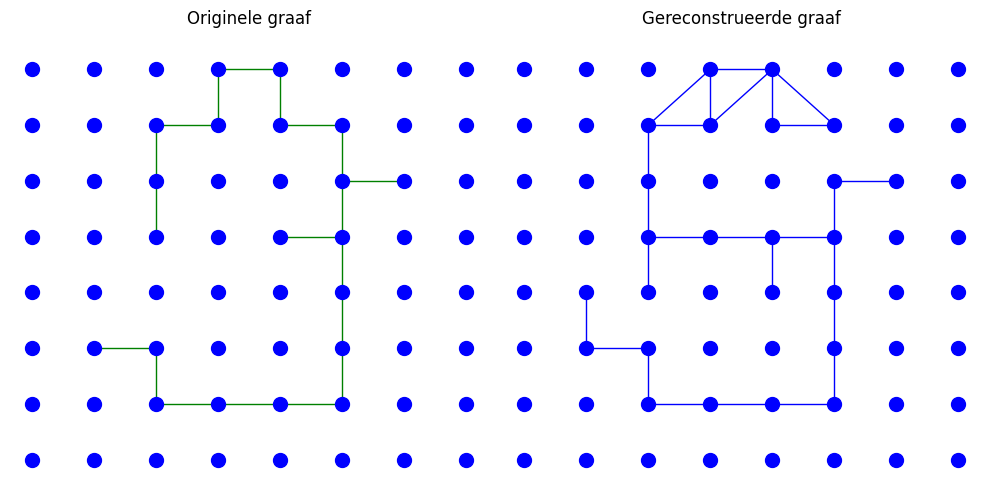

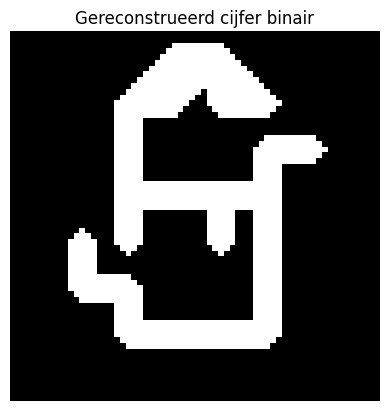

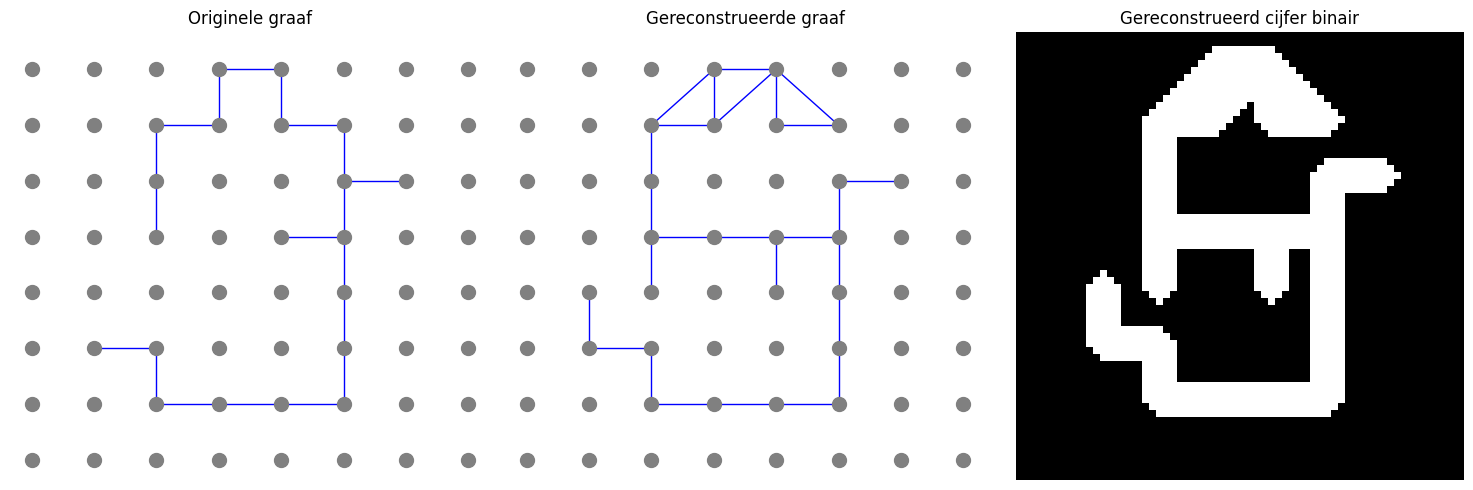

→ Originele voorspelling behouden: 9 (zekerheid: 67.02%) ≥ GNN 51.03%
→ GNN → CNN voorspelling: 6 (zekerheid: 51.03%)


In [14]:
for idx, cijfer in enumerate(slechte_cijfers):
    print(f"\n--- GNN verwerking cijfer {idx+1} ---")

    skeleton = skeleton = preprocess_image(cijfer)
    G = skeleton_to_graph(skeleton)
    G_proj = project_graph_to_grid(G, grid_size=8)
    # G_proj = project_graph_to_grid(G, grid_size=8, image_size=64)

    data = graph_to_pyg_data(G_proj, grid_size=8).to(device)

    # Reconstruct edges
    reconstructed_edges = reconstruct_edges(data, reconstructie_model, threshold=0.96)
    reconstructed_edges, _ = remove_self_loops(reconstructed_edges)
    reconstructed_edges = filter_directe_buren(reconstructed_edges)

    # Visualisatie (optioneel)
    show_comparison(data.edge_index, reconstructed_edges)

    # Maak afbeelding
    digit_img = edge_index_to_image(reconstructed_edges)
    plt.imshow(digit_img, cmap='gray')
    plt.title(f"Gereconstrueerd cijfer binair")
    plt.axis('off')
    plt.show()

        
    import matplotlib.pyplot as plt
    import networkx as nx

    def plot_graph_from_edge_index(edge_index, grid_size=8):
        G = nx.Graph()
        positions = {i: (i % grid_size, grid_size - 1 - i // grid_size) for i in range(grid_size * grid_size)}
        G.add_nodes_from(positions.keys())
        G.add_edges_from(edge_index.t().tolist())
        return G, positions

    # Maak netwerkx grafen van originele en gereconstrueerde edges
    G_orig, pos = plot_graph_from_edge_index(data.edge_index.cpu(), grid_size=8)
    G_recon, _ = plot_graph_from_edge_index(reconstructed_edges.cpu(), grid_size=8)

    # Visualisatie met 3 subplots naast elkaar
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # 1. Originele graaf
    nx.draw(G_orig, pos=pos, ax=axs[0], node_color='gray', edge_color='blue',
            node_size=100, with_labels=False)
    axs[0].set_title("Originele graaf")

    # 2. Gereconstrueerde graaf
    nx.draw(G_recon, pos=pos, ax=axs[1], node_color='gray', edge_color='blue',
            node_size=100, with_labels=False)
    axs[1].set_title("Gereconstrueerde graaf")

    # 3. Gereconstrueerd binair beeld
    axs[2].imshow(digit_img, cmap='gray')
    axs[2].set_title("Gereconstrueerd cijfer binair")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()

    # Naar CNN sturen
    cnn_input = digit_img.astype(np.float32) / 255.0
    cnn_input = cnn_input.reshape(1, 64, 64, 1)
    interpreter.set_tensor(input_details[0]['index'], cnn_input)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    prediction = int(np.argmax(output_data))
    confidence = float(np.max(output_data))

    # Bewaar met originele index
    originele_index = slechte_cijfer_indexen[idx]
    # voorspelde_reeks.append((originele_index, str(prediction)))
    # Vind de oorspronkelijke voorspelling en confidence
    oude_info = next((info for info in slechte_cijfer_info if info[0] == originele_index), None)

    if oude_info is not None:
        _, oude_predictie, oude_conf = oude_info

        if confidence > oude_conf:
            voorspelde_reeks.append((originele_index, str(prediction)))
            print(f"→ GNN → CNN voorspelling: {prediction} (zekerheid: {confidence:.2%}) > oude {oude_conf:.2%}")
        else:
            voorspelde_reeks.append((originele_index, str(oude_predictie)))
            print(f"→ Originele voorspelling behouden: {oude_predictie} (zekerheid: {oude_conf:.2%}) ≥ GNN {confidence:.2%}")
    else:
        # fallback, zou niet moeten gebeuren
        voorspelde_reeks.append((originele_index, str(prediction)))


    print(f"→ GNN → CNN voorspelling: {prediction} (zekerheid: {confidence:.2%})")


# Output

In [15]:
# Sorteer op oorspronkelijke index en toon de reeks
voorspelde_reeks.sort(key=lambda x: x[0])
cijfer_string = ''.join([digit for _, digit in voorspelde_reeks])

print(f"Output: {cijfer_string}")


Output: 591215
